# Search and Load CMIP6 Data via ESGF / OPeNDAP

This notebooks shows how to search and load data via [Earth System Grid Federation](https://esgf.llnl.gov/) infrastructure. This infrastructure works great and is the foundation of the CMIP6 distribution system.

The main technologies used here are the [ESGF search API](https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API), used to figure out what data we want, and [OPeNDAP](https://www.opendap.org/), a remote data access protocol over HTTP.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cftime
import zarr
import cmaps
import s3fs
import cartopy.crs as ccrs

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [2]:
from dask_gateway import Gateway
gateway = Gateway()

In [3]:
##A line of trick to clean your dask cluster before you start your computation
from dask.distributed import Client
clusters=gateway.list_clusters()
print(clusters )
for cluster in clusters :
    cluster= gateway.connect(cluster.name)
    print(cluster)
    client = Client(cluster)
    client.close()
    cluster.shutdown()

[ClusterReport<name=daskhub.2cf8f22340a64c149a28cf04bcbb67f1, status=RUNNING>]
GatewayCluster<daskhub.2cf8f22340a64c149a28cf04bcbb67f1, status=running>


/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:1014: RuntimeWarning: coroutine 'rpc.close_rpc' was never awaited
  self.scheduler_comm.close_rpc()


### Create a new Dask cluster with the Dask Gateway

In [4]:
cluster = gateway.new_cluster(worker_memory=4, worker_cores=1)

cluster.scale(8)
#cluster.adapt(minimum=1, maximum=20, wait_count=10)
cluster

Lets setup the Dask Dashboard with your new cluster.  
This time, copy and past the link above indicated in Dashboard to the dasklab extension.

### Get a client from the Dask Gateway Cluster

As stated above, creating a Dask `Client` is mandatory in order to perform following Daks computations on your Dask Cluster.

In [5]:
from distributed import Client

if cluster:
    client = Client(cluster) # create a dask Gateway cluster
else:
    client = Client()   # create a local dask cluster on the machine.
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /jupyterhub/services/dask-gateway/clusters/daskhub.45b047bdd4c442beb879ddfacd1aac49/status,


### Search using ESGF API

In [2]:
#!/usr/bin/env python
from __future__ import print_function
import requests
import xml.etree.ElementTree as ET
import numpy

# Author: Unknown
# I got the original version from a word document published by ESGF
# https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing

# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = [] 
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)

In [3]:
result = esgf_search(activity_id='HighResMIP', variable_id='so',
                  source_id='CNRM-CM6-1-HR', experiment_id='hist-1950')
result

https://esgf-node.llnl.gov/esg-search/search/?activity_id=HighResMIP&variable_id=so&source_id=CNRM-CM6-1-HR&experiment_id=hist-1950&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=HighResMIP&variable_id=so&source_id=CNRM-CM6-1-HR&experiment_id=hist-1950&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?activity_id=HighResMIP&variable_id=so&source_id=CNRM-CM6-1-HR&experiment_id=hist-1950&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
https://esgf-node.llnl.gov/esg-search/search/?activity_id=HighResMIP&variable_id=so&source_id=CNRM-CM6-1-HR&experiment_id=hist-1950&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=30
https://esgf-node.llnl.gov/esg-search/search/?activity_id=HighResMIP&variable_id=so&source_id=CNRM-CM6-1-HR&experiment_id=hist-1950&project=CMIP6&typ

['https://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/HighResMIP/CNRM-CERFACS/CNRM-CM6-1-HR/hist-1950/r2i1p1f2/Omon/so/gn/v20200615/so_Omon_CNRM-CM6-1-HR_hist-1950_r2i1p1f2_gn_195001-195006.nc',
 'https://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/HighResMIP/CNRM-CERFACS/CNRM-CM6-1-HR/hist-1950/r2i1p1f2/Omon/so/gn/v20200615/so_Omon_CNRM-CM6-1-HR_hist-1950_r2i1p1f2_gn_195007-195012.nc',
 'https://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/HighResMIP/CNRM-CERFACS/CNRM-CM6-1-HR/hist-1950/r2i1p1f2/Omon/so/gn/v20200615/so_Omon_CNRM-CM6-1-HR_hist-1950_r2i1p1f2_gn_195101-195106.nc',
 'https://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/HighResMIP/CNRM-CERFACS/CNRM-CM6-1-HR/hist-1950/r2i1p1f2/Omon/so/gn/v20200615/so_Omon_CNRM-CM6-1-HR_hist-1950_r2i1p1f2_gn_195107-195112.nc',
 'https://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/HighResMIP/CNRM-CERFACS/CNRM-CM6-1-HR/hist-1950/r2i1p1f2/Omon/so/gn/v20200615/so_Omon_CNRM-CM6-1-HR_hist-1950_r2i1p1f2_gn_195201-19

In [4]:
# pick one file for testing
files_to_open = [result[-1]]
files_to_open

['https://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/HighResMIP/CNRM-CERFACS/CNRM-CM6-1-HR/hist-1950/r3i1p1f2/Omon/so/gn/v20200615/so_Omon_CNRM-CM6-1-HR_hist-1950_r3i1p1f2_gn_201407-201412.nc']

### Load Data with Xarray

These are OPeNDAP endpoints. Xarray, together with the netCDF4 python library, allow lazy loading.

In [10]:
ds = xr.open_dataset(files_to_open[0], decode_times=False)
display(ds)

<xarray.Dataset>
Dimensions:      (y: 1050, x: 1442, nvertex: 4, lev: 75, axis_nbounds: 2,
                  time: 6)
Coordinates:
    lat          (y, x) float64 ...
    lon          (y, x) float64 ...
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time         (time) float64 6.01e+04 6.013e+04 ... 6.022e+04 6.025e+04
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    bounds_lon   (y, x, nvertex) float64 ...
    bounds_lat   (y, x, nvertex) float64 ...
    area         (y, x) float64 ...
    lev_bounds   (lev, axis_nbounds) float64 ...
    time_bounds  (time, axis_nbounds) float64 ...
    so           (time, lev, y, x) float32 ...
Attributes: (12/55)
    name:                            /scratch/utmp/ftdir/cglo765/eclis/transf...
    Conventions:                     CF-1.7 CMIP-6.2
    creation_date:                   2018-11-22T03:21:44Z
    tracking_id:                     hdl:21.14100/89136ee2-4e6f-486f-b873-a5b...
    description:                     Coupled integrationswith historic extern...
    title:                           CNRM-CM6-1-HR model output prepared for ...
    ...                              ...
    CMIP6_CV_version:                cv=6.2.3.0-7-g2019642
    dr2xml_md5sum:                   92ddb3d0d8ce79f498d792fc8e559dcf
    xios_commit:                     1442-shuffle
    nemo_gelato_commit:              f845920e7f2169d_8250e198106a168
    arpege_minor_version:            6.3.2
    DODS_EXTRA.Unlimited_Dimension:  time

In [11]:
ds = ds.sel(y=slice(300,700), x=slice(300,700))
ds

<xarray.Dataset>
Dimensions:      (y: 400, x: 400, nvertex: 4, lev: 75, axis_nbounds: 2, time: 6)
Coordinates:
    lat          (y, x) float64 ...
    lon          (y, x) float64 ...
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time         (time) float64 6.01e+04 6.013e+04 ... 6.022e+04 6.025e+04
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    bounds_lon   (y, x, nvertex) float64 ...
    bounds_lat   (y, x, nvertex) float64 ...
    area         (y, x) float64 ...
    lev_bounds   (lev, axis_nbounds) float64 0.0 1.024 ... 5.8e+03 6.004e+03
    time_bounds  (time, axis_nbounds) float64 6.008e+04 6.011e+04 ... 6.026e+04
    so           (time, lev, y, x) float32 ...
Attributes: (12/55)
    name:                            /scratch/utmp/ftdir/cglo765/eclis/transf...
    Conventions:                     CF-1.7 CMIP-6.2
    creation_date:                   2018-11-22T03:21:44Z
    tracking_id:                     hdl:21.14100/89136ee2-4e6f-486f-b873-a5b...
    description:                     Coupled integrationswith historic extern...
    title:                           CNRM-CM6-1-HR model output prepared for ...
    ...                              ...
    CMIP6_CV_version:                cv=6.2.3.0-7-g2019642
    dr2xml_md5sum:                   92ddb3d0d8ce79f498d792fc8e559dcf
    xios_commit:                     1442-shuffle
    nemo_gelato_commit:              f845920e7f2169d_8250e198106a168
    arpege_minor_version:            6.3.2
    DODS_EXTRA.Unlimited_Dimension:  time

In [12]:
ds.nbytes*1e-9

0.302081944

CPU times: user 99.9 ms, sys: 17.5 ms, total: 117 ms
Wall time: 7.74 s


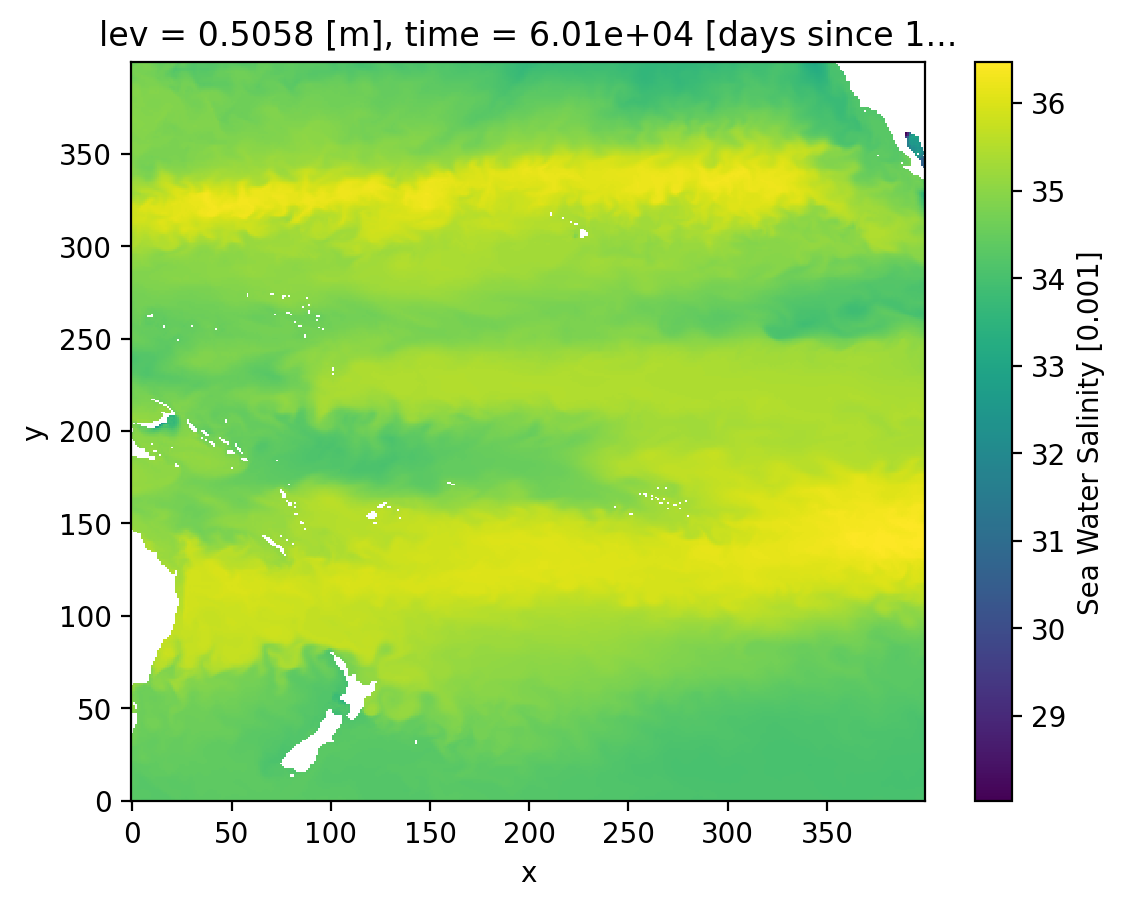

In [13]:
%%time
ds.so.isel(time=0, lev=0).plot()

In [14]:
ds = ds.compute()
ds

<xarray.Dataset>
Dimensions:      (y: 400, x: 400, nvertex: 4, lev: 75, axis_nbounds: 2, time: 6)
Coordinates:
    lat          (y, x) float64 -49.25 -49.25 -49.25 ... 38.62 38.62 38.62
    lon          (y, x) float64 147.8 148.0 148.2 148.5 ... -113.0 -112.7 -112.5
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time         (time) float64 6.01e+04 6.013e+04 ... 6.022e+04 6.025e+04
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    bounds_lon   (y, x, nvertex) float64 147.6 147.9 147.9 ... -112.3 -112.6
    bounds_lat   (y, x, nvertex) float64 -49.33 -49.33 -49.17 ... 38.7 38.7
    area         (y, x) float64 3.293e+08 3.293e+08 ... 4.081e+08 4.08e+08
    lev_bounds   (lev, axis_nbounds) float64 0.0 1.024 ... 5.8e+03 6.004e+03
    time_bounds  (time, axis_nbounds) float64 6.008e+04 6.011e+04 ... 6.026e+04
    so           (time, lev, y, x) float32 34.27 34.26 34.26 ... nan nan nan
Attributes: (12/55)
    name:                            /scratch/utmp/ftdir/cglo765/eclis/transf...
    Conventions:                     CF-1.7 CMIP-6.2
    creation_date:                   2018-11-22T03:21:44Z
    tracking_id:                     hdl:21.14100/89136ee2-4e6f-486f-b873-a5b...
    description:                     Coupled integrationswith historic extern...
    title:                           CNRM-CM6-1-HR model output prepared for ...
    ...                              ...
    CMIP6_CV_version:                cv=6.2.3.0-7-g2019642
    dr2xml_md5sum:                   92ddb3d0d8ce79f498d792fc8e559dcf
    xios_commit:                     1442-shuffle
    nemo_gelato_commit:              f845920e7f2169d_8250e198106a168
    arpege_minor_version:            6.3.2
    DODS_EXTRA.Unlimited_Dimension:  time

In [22]:
ds = ds.persist()
ds

<xarray.Dataset>
Dimensions:      (y: 1050, x: 1442, nvertex: 4, lev: 75, axis_nbounds: 2,
                  time: 6)
Coordinates:
    lat          (y, x) float64 dask.array<chunksize=(1050, 1442), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(1050, 1442), meta=np.ndarray>
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time         (time) float64 6.01e+04 6.013e+04 ... 6.022e+04 6.025e+04
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    bounds_lon   (y, x, nvertex) float64 dask.array<chunksize=(1050, 1442, 4), meta=np.ndarray>
    bounds_lat   (y, x, nvertex) float64 dask.array<chunksize=(1050, 1442, 4), meta=np.ndarray>
    area         (y, x) float64 dask.array<chunksize=(1050, 1442), meta=np.ndarray>
    lev_bounds   (lev, axis_nbounds) float64 dask.array<chunksize=(75, 2), meta=np.ndarray>
    time_bounds  (time, axis_nbounds) float64 dask.array<chunksize=(6, 2), meta=np.ndarray>
    so           (time, lev, y, x) float32 dask.array<chunksize=(1, 75, 1050, 1442), meta=np.ndarray>
Attributes: (12/55)
    name:                            /scratch/utmp/ftdir/cglo765/eclis/transf...
    Conventions:                     CF-1.7 CMIP-6.2
    creation_date:                   2018-11-22T03:21:44Z
    tracking_id:                     hdl:21.14100/89136ee2-4e6f-486f-b873-a5b...
    description:                     Coupled integrationswith historic extern...
    title:                           CNRM-CM6-1-HR model output prepared for ...
    ...                              ...
    CMIP6_CV_version:                cv=6.2.3.0-7-g2019642
    dr2xml_md5sum:                   92ddb3d0d8ce79f498d792fc8e559dcf
    xios_commit:                     1442-shuffle
    nemo_gelato_commit:              f845920e7f2169d_8250e198106a168
    arpege_minor_version:            6.3.2
    DODS_EXTRA.Unlimited_Dimension:  time

In [23]:
from xmip.preprocessing import rename_cmip6

ds = rename_cmip6(ds)
ds

<xarray.Dataset>
Dimensions:      (y: 1050, x: 1442, vertex: 4, lev: 75, bnds: 2, time: 6)
Coordinates:
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time         (time) float64 6.01e+04 6.013e+04 ... 6.022e+04 6.025e+04
Dimensions without coordinates: y, x, vertex, bnds
Data variables:
    lat          (y, x) float64 dask.array<chunksize=(1050, 1442), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(1050, 1442), meta=np.ndarray>
    lon_bounds   (y, x, vertex) float64 dask.array<chunksize=(1050, 1442, 4), meta=np.ndarray>
    lat_bounds   (y, x, vertex) float64 dask.array<chunksize=(1050, 1442, 4), meta=np.ndarray>
    area         (y, x) float64 dask.array<chunksize=(1050, 1442), meta=np.ndarray>
    lev_bounds   (lev, bnds) float64 dask.array<chunksize=(75, 2), meta=np.ndarray>
    time_bounds  (time, bnds) float64 dask.array<chunksize=(6, 2), meta=np.ndarray>
    so           (time, lev, y, x) float32 dask.array<chunksize=(1, 75, 1050, 1442), meta=np.ndarray>
Attributes: (12/55)
    name:                            /scratch/utmp/ftdir/cglo765/eclis/transf...
    Conventions:                     CF-1.7 CMIP-6.2
    creation_date:                   2018-11-22T03:21:44Z
    tracking_id:                     hdl:21.14100/89136ee2-4e6f-486f-b873-a5b...
    description:                     Coupled integrationswith historic extern...
    title:                           CNRM-CM6-1-HR model output prepared for ...
    ...                              ...
    CMIP6_CV_version:                cv=6.2.3.0-7-g2019642
    dr2xml_md5sum:                   92ddb3d0d8ce79f498d792fc8e559dcf
    xios_commit:                     1442-shuffle
    nemo_gelato_commit:              f845920e7f2169d_8250e198106a168
    arpege_minor_version:            6.3.2
    DODS_EXTRA.Unlimited_Dimension:  time

In [24]:
# subset Northern hemisphere
ds = ds.where(ds['lat']>=20)
ds

<xarray.Dataset>
Dimensions:      (y: 1050, x: 1442, vertex: 4, lev: 75, bnds: 2, time: 6)
Coordinates:
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time         (time) float64 6.01e+04 6.013e+04 ... 6.022e+04 6.025e+04
Dimensions without coordinates: y, x, vertex, bnds
Data variables:
    lat          (y, x) float64 dask.array<chunksize=(1050, 1442), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(1050, 1442), meta=np.ndarray>
    lon_bounds   (y, x, vertex) float64 dask.array<chunksize=(1050, 1442, 4), meta=np.ndarray>
    lat_bounds   (y, x, vertex) float64 dask.array<chunksize=(1050, 1442, 4), meta=np.ndarray>
    area         (y, x) float64 dask.array<chunksize=(1050, 1442), meta=np.ndarray>
    lev_bounds   (lev, bnds, y, x) float64 dask.array<chunksize=(75, 2, 1050, 1442), meta=np.ndarray>
    time_bounds  (time, bnds, y, x) float64 dask.array<chunksize=(6, 2, 1050, 1442), meta=np.ndarray>
    so           (time, lev, y, x) float32 dask.array<chunksize=(1, 75, 1050, 1442), meta=np.ndarray>
Attributes: (12/55)
    name:                            /scratch/utmp/ftdir/cglo765/eclis/transf...
    Conventions:                     CF-1.7 CMIP-6.2
    creation_date:                   2018-11-22T03:21:44Z
    tracking_id:                     hdl:21.14100/89136ee2-4e6f-486f-b873-a5b...
    description:                     Coupled integrationswith historic extern...
    title:                           CNRM-CM6-1-HR model output prepared for ...
    ...                              ...
    CMIP6_CV_version:                cv=6.2.3.0-7-g2019642
    dr2xml_md5sum:                   92ddb3d0d8ce79f498d792fc8e559dcf
    xios_commit:                     1442-shuffle
    nemo_gelato_commit:              f845920e7f2169d_8250e198106a168
    arpege_minor_version:            6.3.2
    DODS_EXTRA.Unlimited_Dimension:  time

CPU times: user 250 ms, sys: 17.7 ms, total: 268 ms
Wall time: 625 ms


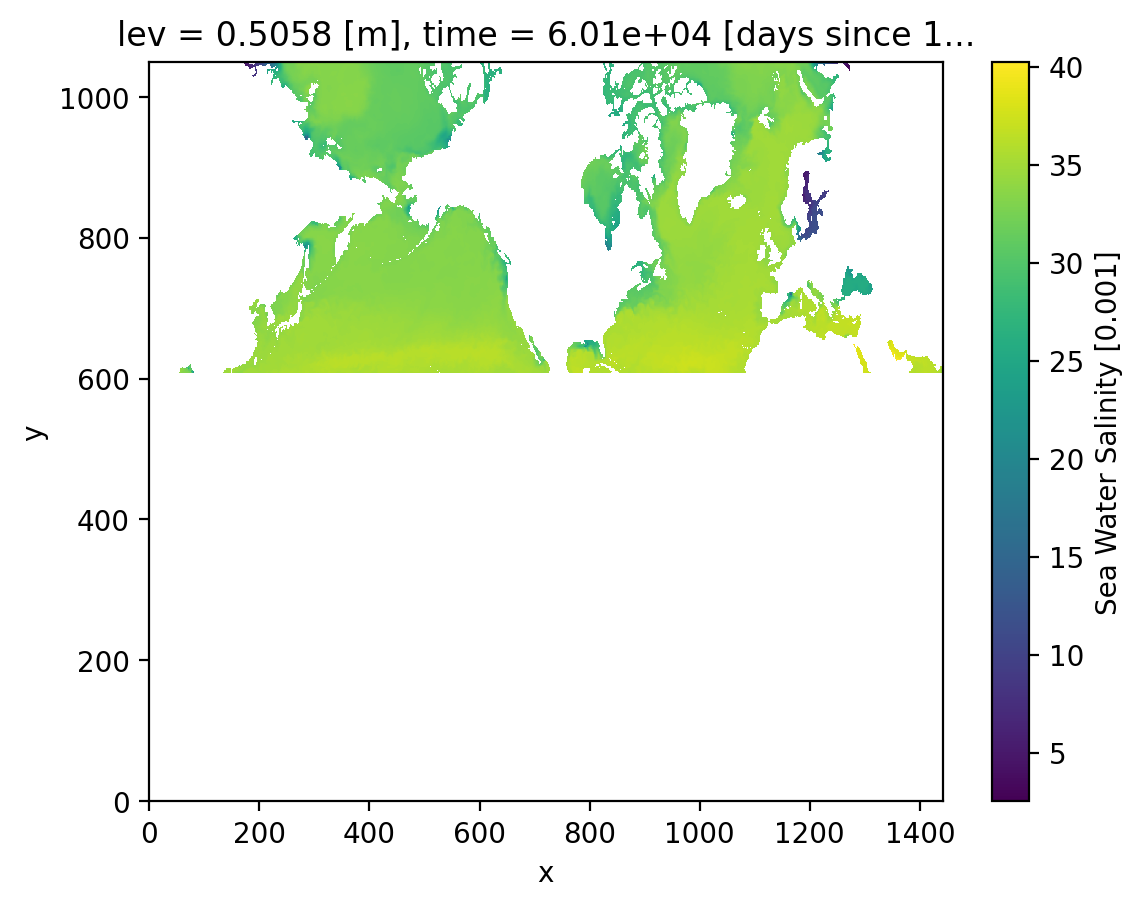

In [25]:
%%time
ds.so.isel(time=0, lev=0).plot()

In [26]:
ds.nbytes*1e-9


4.820895048000001

In [16]:
ds = ds.chunk(chunks={'x':100,'y':100}).persist()
ds

<xarray.Dataset>
Dimensions:      (y: 1050, x: 1442, vertex: 4, lev: 75, bnds: 2, time: 6)
Coordinates:
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time         (time) float64 6.01e+04 6.013e+04 ... 6.022e+04 6.025e+04
Dimensions without coordinates: y, x, vertex, bnds
Data variables:
    lat          (y, x) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    lon_bounds   (y, x, vertex) float64 dask.array<chunksize=(100, 100, 4), meta=np.ndarray>
    lat_bounds   (y, x, vertex) float64 dask.array<chunksize=(100, 100, 4), meta=np.ndarray>
    area         (y, x) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    lev_bounds   (lev, bnds, y, x) float64 dask.array<chunksize=(75, 2, 100, 100), meta=np.ndarray>
    time_bounds  (time, bnds, y, x) float64 dask.array<chunksize=(6, 2, 100, 100), meta=np.ndarray>
    so           (time, lev, y, x) float32 dask.array<chunksize=(1, 75, 100, 100), meta=np.ndarray>
Attributes: (12/55)
    name:                            /scratch/utmp/ftdir/cglo765/eclis/transf...
    Conventions:                     CF-1.7 CMIP-6.2
    creation_date:                   2018-11-22T03:21:44Z
    tracking_id:                     hdl:21.14100/89136ee2-4e6f-486f-b873-a5b...
    description:                     Coupled integrationswith historic extern...
    title:                           CNRM-CM6-1-HR model output prepared for ...
    ...                              ...
    CMIP6_CV_version:                cv=6.2.3.0-7-g2019642
    dr2xml_md5sum:                   92ddb3d0d8ce79f498d792fc8e559dcf
    xios_commit:                     1442-shuffle
    nemo_gelato_commit:              f845920e7f2169d_8250e198106a168
    arpege_minor_version:            6.3.2
    DODS_EXTRA.Unlimited_Dimension:  time

In [15]:
# Testing test data upload
your_name='asiddi24'
path='EXCHANGES/'+your_name
s3_prefix =  "s3://"+path
print(s3_prefix)
access_key = !aws configure get aws_access_key_id
access_key = access_key[0]
# secret_key = !aws configure get aws_secret_access_key
# secret_key = secret_key[0]
secret_key = 'e68cfb2dddf145748439ee03fdc076c7'
client_kwargs={'endpoint_url': 'https://object-store.cloud.muni.cz'}

s3://EXCHANGES/asiddi24


In [ ]:
#access_key

In [ ]:
#secret_key

In [19]:
target = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://object-store.cloud.muni.cz'
      })
target.ls(path)

[]

In [54]:
target.rm(path,recursive=True)

In [55]:
zarr_file_name= "test_CNRM_CM6-1-HR"
uri = f"{s3_prefix}/{zarr_file_name}"
store = zarr.storage.FSStore(uri, client_kwargs=client_kwargs,key=access_key, secret=secret_key)
store.map.fs.find(uri)

['EXCHANGES/asiddi24/test_CNRM_CM6-1-HR']

In [58]:
ds.to_zarr('./test.zarr')

In [59]:
ds = ds.rename({'so':'stest'})
ds

<xarray.Dataset>
Dimensions:      (y: 400, x: 400, nvertex: 4, lev: 75, axis_nbounds: 2, time: 6)
Coordinates:
    lat          (y, x) float64 -49.25 -49.25 -49.25 ... 38.62 38.62 38.62
    lon          (y, x) float64 147.8 148.0 148.2 148.5 ... -113.0 -112.7 -112.5
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time         (time) float64 6.01e+04 6.013e+04 ... 6.022e+04 6.025e+04
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    bounds_lon   (y, x, nvertex) float64 147.6 147.9 147.9 ... -112.3 -112.6
    bounds_lat   (y, x, nvertex) float64 -49.33 -49.33 -49.17 ... 38.7 38.7
    area         (y, x) float64 3.293e+08 3.293e+08 ... 4.081e+08 4.08e+08
    lev_bounds   (lev, axis_nbounds) float64 0.0 1.024 ... 5.8e+03 6.004e+03
    time_bounds  (time, axis_nbounds) float64 6.008e+04 6.011e+04 ... 6.026e+04
    stest        (time, lev, y, x) float32 34.27 34.26 34.26 ... nan nan nan
Attributes: (12/55)
    name:                            /scratch/utmp/ftdir/cglo765/eclis/transf...
    Conventions:                     CF-1.7 CMIP-6.2
    creation_date:                   2018-11-22T03:21:44Z
    tracking_id:                     hdl:21.14100/89136ee2-4e6f-486f-b873-a5b...
    description:                     Coupled integrationswith historic extern...
    title:                           CNRM-CM6-1-HR model output prepared for ...
    ...                              ...
    CMIP6_CV_version:                cv=6.2.3.0-7-g2019642
    dr2xml_md5sum:                   92ddb3d0d8ce79f498d792fc8e559dcf
    xios_commit:                     1442-shuffle
    nemo_gelato_commit:              f845920e7f2169d_8250e198106a168
    arpege_minor_version:            6.3.2
    DODS_EXTRA.Unlimited_Dimension:  time

In [60]:
%time 
# from dask.diagnostics import ProgressBar
# from dask.distributed import progress

ds.to_zarr(store=store, mode='w', consolidated=True)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 11.2 µs


KeyError: 'lon'

In [ ]:
client.close()

In [33]:
for var in ds:
    del ds[var].encoding['']

SyntaxError: cannot delete function call (29427500.py, line 2)

In [49]:
for var in ds:
    for items in  ds[var].encoding :
        del(ds[var].encoding[items])

RuntimeError: dictionary changed size during iteration

In [52]:
ds.so.encoding

{}

In [51]:
del(ds.so.encoding['_FillValue'])

In [31]:
del(ds.so.encoding)
print(ds.so.encoding)

AttributeError: can't delete attribute

In [53]:
ds

<xarray.Dataset>
Dimensions:      (y: 400, x: 400, nvertex: 4, lev: 75, axis_nbounds: 2, time: 6)
Coordinates:
    lat          (y, x) float64 -49.25 -49.25 -49.25 ... 38.62 38.62 38.62
    lon          (y, x) float64 147.8 148.0 148.2 148.5 ... -113.0 -112.7 -112.5
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time         (time) float64 6.01e+04 6.013e+04 ... 6.022e+04 6.025e+04
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    bounds_lon   (y, x, nvertex) float64 147.6 147.9 147.9 ... -112.3 -112.6
    bounds_lat   (y, x, nvertex) float64 -49.33 -49.33 -49.17 ... 38.7 38.7
    area         (y, x) float64 3.293e+08 3.293e+08 ... 4.081e+08 4.08e+08
    lev_bounds   (lev, axis_nbounds) float64 0.0 1.024 ... 5.8e+03 6.004e+03
    time_bounds  (time, axis_nbounds) float64 6.008e+04 6.011e+04 ... 6.026e+04
    so           (time, lev, y, x) float32 34.27 34.26 34.26 ... nan nan nan
Attributes: (12/55)
    name:                            /scratch/utmp/ftdir/cglo765/eclis/transf...
    Conventions:                     CF-1.7 CMIP-6.2
    creation_date:                   2018-11-22T03:21:44Z
    tracking_id:                     hdl:21.14100/89136ee2-4e6f-486f-b873-a5b...
    description:                     Coupled integrationswith historic extern...
    title:                           CNRM-CM6-1-HR model output prepared for ...
    ...                              ...
    CMIP6_CV_version:                cv=6.2.3.0-7-g2019642
    dr2xml_md5sum:                   92ddb3d0d8ce79f498d792fc8e559dcf
    xios_commit:                     1442-shuffle
    nemo_gelato_commit:              f845920e7f2169d_8250e198106a168
    arpege_minor_version:            6.3.2
    DODS_EXTRA.Unlimited_Dimension:  time